In [1]:
import os
import json
from uncertainties import ufloat, umath
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

from functions import Qf2σ, prettifySample

<ipython-input-2-5e3347349b45>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(["0.40","0.50", "0.60", "0.70"])
<ipython-input-2-5e3347349b45>:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


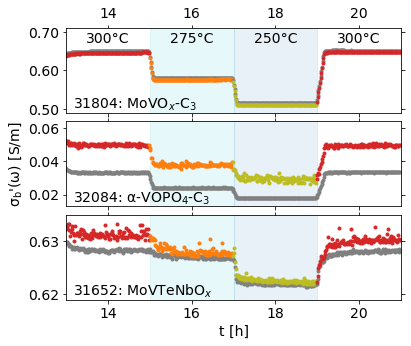

In [2]:
sids = [
    "2019-11-05-31804-ex-31012-propane-01", 
    "2019-12-09-32084-ex-31915-propane-01", 
    "2019-12-05-31652-propane-01"
]
fig = plt.figure(figsize=(6,5))
grid = plt.GridSpec(3, 100, wspace=0.1, hspace=0.1, figure=fig)
ax = []
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))

ai = 0
for sid in sids:
    with open(os.path.join("..", "data", "ex_twomode", sid + ".datagram.json"), "r") as infile:
        dg = json.load(infile)
    with open(os.path.join("..", "data", "ex_twomode", sid + ".params.json"), "r") as infile:
        params = json.load(infile)

    mcptdata = [i for i in dg if i["input"]["datagram"] == "qftrace"]

    A = params["mcpt"]["A"]
    B = params["mcpt"]["B"]
    C = params["mcpt"]["C"]
    ffac = 1 / params["mcpt"]["rp_nm"]
    c_i = params["cavity"]["i"]
    s_i = params["sample"]["i"]
    Vs = np.pi * ufloat(*params["sample"]["r"])**2 * ufloat(*params["sample"]["h"])
    Vc = np.pi * ufloat(*params["cavity"]["r"])**2 * ufloat(*params["cavity"]["h"])
    delta = (ufloat(*params["sample"]["m"]) / ufloat(*params["sample"]["rho"])) * (1 / Vs)

    timestamps = []
    for section in mcptdata:
        if params["reference"] in section["input"]["export"]:
            Q_c = ufloat(np.average([p["Q0"][c_i] for p in section["results"][-10:-1]]), 
                         np.std([p["Q0"][c_i] for p in section["results"][-10:-1]]))
            f_c = ufloat(np.average([p["f0"][c_i] for p in section["results"][-10:-1]]), 
                         np.std([p["f0"][c_i] for p in section["results"][-10:-1]]))
        for p in section["results"]:
            timestamps.append(p["uts"])
    t0 = min(timestamps)
    Q0c = ufloat(*params["cavity"]["Q"]["TM020"])
    f0c = f_c * ffac
    Qfac = ufloat(*params["cavity"]["Q"]["TM020"])/Q_c
    ffac = ufloat(1 / params["mcpt"]["rp_nm"], 0)

    colors = ["C3","C1","C8","C3"]
    for section in mcptdata[5:9]:
        t = []
        s2 = []
        sc = []
        for p in section["results"]:
            f0 = p["f0"][c_i] * ffac
            Q0 = p["Q0"][c_i] * Qfac
            fs = p["f0"][s_i]
            Qs = p["Q0"][s_i]
            t.append((p["uts"] - t0)/3600)
            s2.append(Qf2σ(Qs, Q0, fs, f0, Vs, Vc, A = A, B = B, C = C, delta = delta)["σ"].n)
            sc.append(Qf2σ(Qs, Q0c, fs, f0c, Vs, Vc, A = A, B = B, C = C, delta = delta)["σ"].n)
        ax[ai].plot(t, sc, marker=".", linestyle=" ", color="0.5")
        ax[ai].plot(t, s2, marker=".", linestyle=" ", color=colors.pop(0))
    ax[ai].tick_params(left=True, right=True, top=True, bottom=True)
    ax[ai].tick_params(labelleft=True, labelright=False, labeltop=False, labelbottom=False)
    ax[ai].set_xlim(left=13, right=21)
    ax[ai].text(0.02, 0.0, f"{params['sample']['id']}: {prettifySample(params['sample']['name'])}" , ha='left', va='bottom', transform = ax[ai].transAxes)
    ai += 1
ax[0].set_ylim(bottom=0.49, top=0.71)
ax[0].set_yticklabels(["0.40","0.50", "0.60", "0.70"])
ax[1].set_ylim(bottom=0.013, top=0.064)
ax[2].set_ylim(bottom=0.619, top=0.635)

ax[0].tick_params(labeltop=True)
ax[2].tick_params(labelbottom=True)

ax[0].text(14,0.7,"300°C", ha="center", va="top")
ax[0].text(16,0.7,"275°C", ha="center", va="top")
ax[0].text(18,0.7,"250°C", ha="center", va="top")
ax[0].text(20,0.7,"300°C", ha="center", va="top")

for a in ax:
    a.fill_between([15,17],[1,1], color="C9", alpha=0.1, zorder=0)
    a.fill_between([17,19],[1,1], color="C0", alpha=0.1, zorder=0)


ax[1].set_ylabel("σ$_\mathrm{b}$'(ω) [S/m]")
ax[2].set_xlabel("t [h]")
fig.show()
fig.savefig(os.path.join("..", "outputs", "sig_twomode.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")